Loading model...
Loading image...
Colorizing...


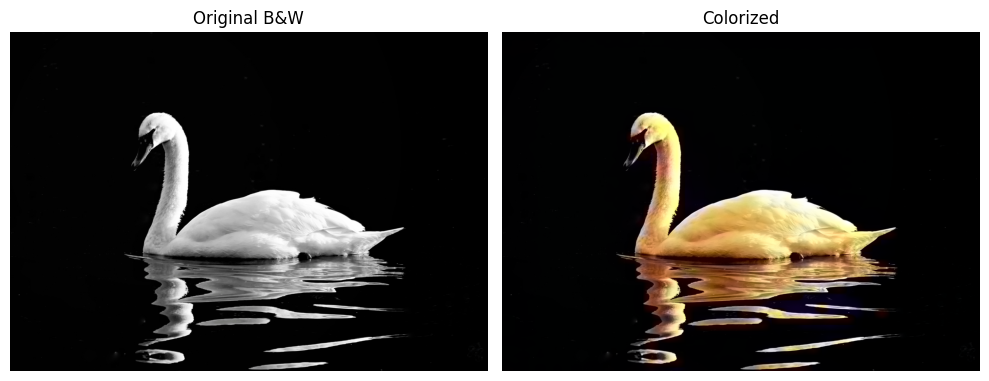

In [4]:
# Image Colorization in Jupyter Notebook

import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

# Paths to pre-trained model files
DIR = r"./colorize"
PROTOTXT = os.path.join(DIR, "colorization_deploy_v2.prototxt")
POINTS = os.path.join(DIR, "pts_in_hull.npy")
MODEL = os.path.join(DIR, "colorization_release_v2.caffemodel")

# Path to input black & white image
IMAGE_PATH = "./images/swan.jpg"  # Change this to your image path

# 🔎 Validate all required files
if not os.path.isfile(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")
if not os.path.isfile(PROTOTXT) or not os.path.isfile(MODEL) or not os.path.isfile(POINTS):
    raise FileNotFoundError("One or more model files are missing from the colorize/ directory.")

# 📥 Load pre-trained Caffe model
print("Loading model...")
net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
pts = np.load(POINTS)

# 🎯 Set AB cluster centers as 1x1 convolution kernel
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

# 🖼️ Load input image
print("Loading image...")
image = cv2.imread(IMAGE_PATH)
if image is None:
    raise ValueError("Image could not be read. Check path or file format.")

# 📐 Preprocess
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50  # Mean-centering as per model training

# 🧠 Colorization
print("Colorizing...")
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")

# 📊 Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original B&W")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB))
plt.title("Colorized")
plt.axis("off")
plt.tight_layout()
plt.show()
